In [2]:
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read the data

In [3]:
#todds_file = "../data/OpenBCI-RAW-2017-08-25_17-30-04_adrian_first_recording.txt"
todds_file = "../data/OpenBCI-RAW-2017-08-28_11-10-26_entrainment.txt"
#todds_file = "../data/OpenBCI-RAW-2017-08-25_17-15-04_Niko second_recording.txt"
adrians_file = "../data/OpenBCI-RAW-2017-08-10_15-06-15.txt"
zeus_file = "../data/OpenBCI-RAW-2017-08-10_15-19-42.txt"
data = {"todd":{"filename":todds_file}, "adrian":{"filename":adrians_file},"zeus":{"filename":zeus_file}}

In [4]:
def read_eeg_data(filename, channel_count=16, accel=True, final_col="Timestamp", set_time_index=True):
    """Reads eeg data with options for number of channels and different OpenBCI data formats"""
    data_cols = ["Channel_"+str(i) for i in range(channel_count)] 
    if accel:
        data_cols = data_cols + ["Accel_"+str(i) for i in range(3)]
    columns = ["SampleIndex"] + data_cols + [final_col]
    df = pd.read_csv(filename,names=columns,skiprows=6)
    # drop first second and last second
    df = df.iloc[256:-256]
    if set_time_index:
        df.set_index(keys='Timestamp', inplace=True)
    return df

In [5]:
data = read_eeg_data(todds_file)

In [6]:
sampling_rate = 256 #hz

In [7]:
def view_segment(df, channel_count=16, start_index=0, stop_index=-1, sampling_rate=sampling_rate):
    """View the raw EEG signals"""
    duration=int(len(df.iloc[start_index:stop_index])/sampling_rate)
    print("{} seconds of recording".format(duration))
    df.iloc[start_index:stop_index][["Channel_"+str(i) for i in range(channel_count)]].plot(figsize=(16,9))
    plt.legend(loc=6)
    plt.xlabel('Timestamp',fontsize=22)
    plt.ylabel('Relative microvolts (uV)',fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=22)
    plt.show()

83 seconds of recording


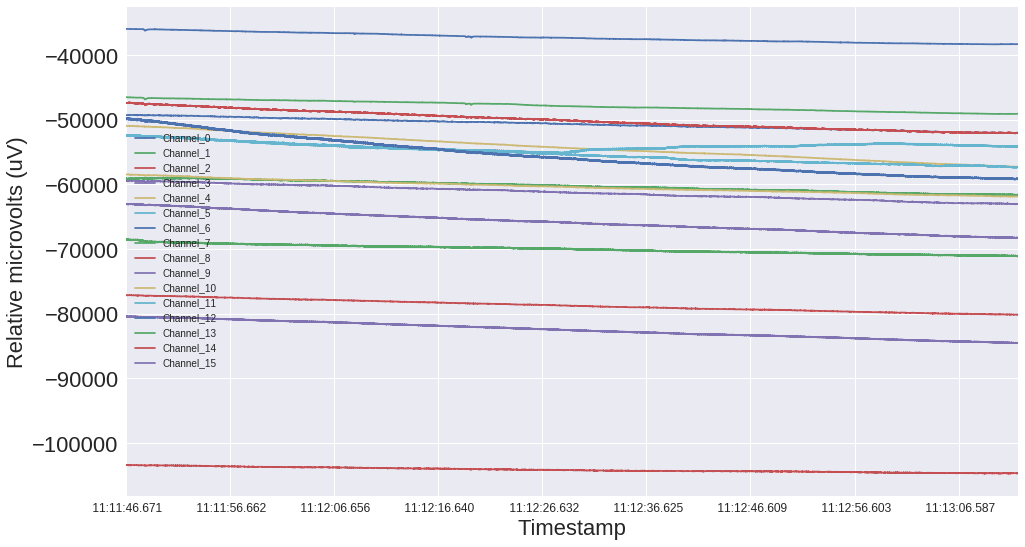

In [8]:
view_segment(data, channel_count=16, start_index=10000, stop_index=-3000)

In [9]:
def envelope_plot(df, channel_count=16, start_index=1000, duration=256):
    """Zooms in on a shorter segment, such as one second, and plots the results"""
    f, axarr = plt.subplots(channel_count, sharex=True)
    for i in range(channel_count):
        df.iloc[start_index:start_index+sampling_rate][["Channel_" + str(i)]].plot(ax=axarr[i],figsize=(16,9))
    plt.show()

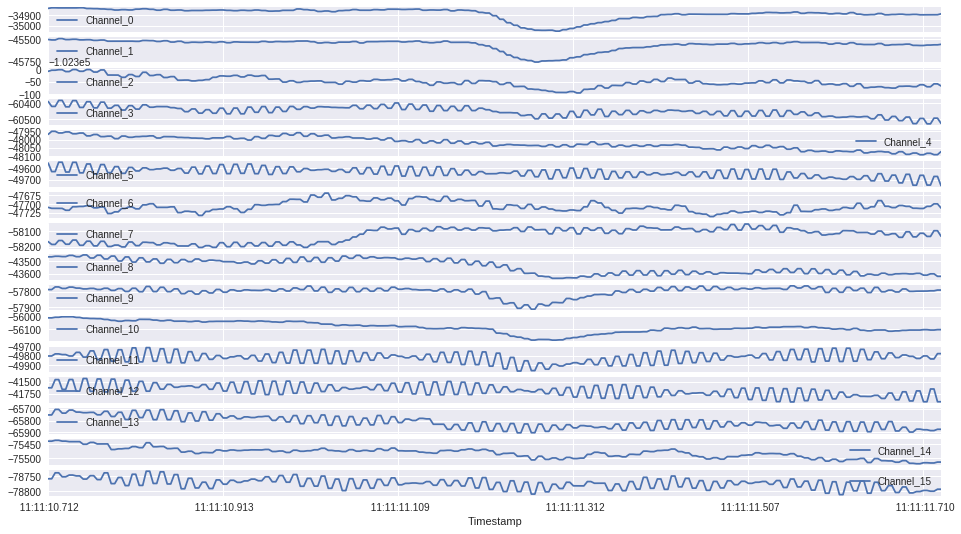

In [10]:
envelope_plot(data)

In [11]:
def bandpass_filter(df, channel=8, highpass_freq=1., lowpass_freq=40., notch_freqs=[60.,120.], sampling_rate=sampling_rate):
    """Filters out specified frequencies +/- 3 hz, mostly to filter out interference from the utility power
    transmission frequency"""
    # https://github.com/chipaudette/EEGHacker/blob/master/Data/2014-10-03%20V3%20Alpha/exploreData.py
    # filter the data to remove DC
    signal_data = df["Channel_{}".format(channel)]
    print("highpass filtering at: " + str(highpass_freq) + " Hz")
    b, a = signal.butter(2, highpass_freq/(sampling_rate / 2.0), 'highpass')  # define the filter
    clean_signal = signal.lfilter(b, a, signal_data, 0) # apply along the zeroeth dimension
    
    print("lowpass filtering at: " + str(lowpass_freq) + " Hz")
    b, a = signal.butter(2, lowpass_freq/(sampling_rate / 2.0), 'lowpass')  # define the filter
    clean_signal = signal.lfilter(b, a, signal_data, 0) # apply along the zeroeth dimension

    # notch filter the data to remove 60 Hz and 120 Hz interference
    for freq_Hz in notch_freqs:  # loop over each center freq
        bp_stop_Hz = freq_Hz + 3.0*np.array([-1, 1])  # set the stop band
        print("notch filtering: " + str(bp_stop_Hz[0]) + "-" + str(bp_stop_Hz[1]) + " Hz")
        b, a = signal.butter(3, bp_stop_Hz/(sampling_rate / 2.0), 'bandstop')  # create the filter
        clean_signal = signal.lfilter(b, a, clean_signal, 0)  # apply along the zeroeth dimension
    
    return clean_signal

In [12]:
def spectrogram(signal, NFFT=1024, overlap=.1, sampling_rate=sampling_rate, min_freq=0, max_freq=40, plot=False):
    """https://matplotlib.org/examples/pylab_examples/specgram_demo.html
    Pxx is the segments x freqs array of instantaneous power, freqs is
    the frequency vector, bins are the centers of the time bins in which
    the power is computed, and im is the matplotlib.image.AxesImage
    instance"""
    
    NFFT = int(NFFT) # length of the fft
    overlap = NFFT - int(overlap * NFFT)  

    fig = plt.figure(figsize=(30, 9))

    Pxx, freqs, bins, im = plt.specgram(signal,NFFT=NFFT,\
                                        Fs=sampling_rate, noverlap=overlap, \
                                        cmap=plt.get_cmap('viridis'))

    Pxx_perbin = Pxx * sampling_rate / float(NFFT)  #convert to "per bin"
    
    if plot:
        plt.pcolor(bins, freqs, 10*np.log10(Pxx_perbin), cmap=plt.get_cmap('jet'))  # dB re: 1 uV
        plt.clim(-20, 10)
        plt.xlim(bins[0], bins[-1])
        plt.ylim(min_freq,max_freq)
        plt.xlabel('Time (sec)',fontsize=22)
        plt.ylabel('Frequency (Hz)',fontsize=22)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.show()
    
    return Pxx_perbin, freqs, bins

6
highpass filtering at: 1.0 Hz
lowpass filtering at: 40.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


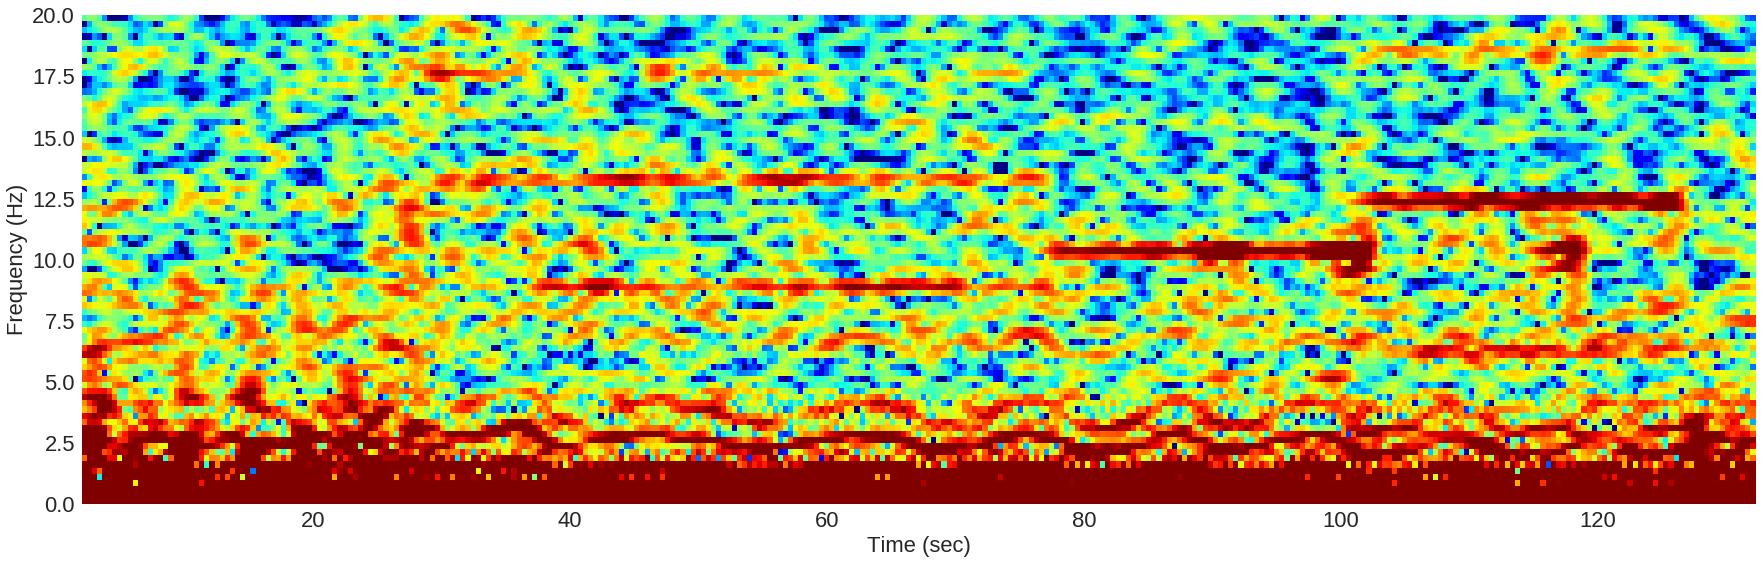

In [13]:
start=120*256
stop=256*175

for chan in [6]:    
    print(chan)
    raw_signal = bandpass_filter(data,channel=chan)#[start:stop]
    power, freqs, time_steps = spectrogram(raw_signal, min_freq=0,max_freq=20, plot=True)

In [51]:
freqs[41:42]

array([ 10.25])

In [58]:
alpha_data = np.mean(power[35:36,1:],axis=0)
#alpha_data = np.mean(power[40:42,50:],axis=0)
#alpha_data = np.mean(power[49:51,50:],axis=0)

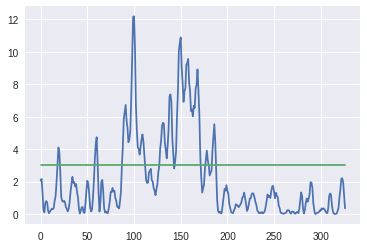

In [59]:
signal_length = len(alpha_data)
threshold = signal_length*[3]
plt.plot(alpha_data)
plt.plot(threshold)

### Try to detect entrained signals

In [13]:
def fft(data, sampling_rate=256, lower_freq=0., upper_freq=40.):
    n = len(data) # length of the signal
    k = np.arange(n) # array of timesteps in observations
    T = n/float(sampling_rate) # number of sampling cycles 
    freqs = k/np.float(T) # two sides frequency range 
    freqs = freqs[range(int(n/2))] # one side frequency range # due to nyquist frequency

    mask = np.logical_and(freqs >= lower_freq, freqs <= upper_freq)

    Y = np.fft.fft(data)*2/n # fft computing and normalization # why normalize? again a result of the nyquist frequency
    Y = Y[range(int(n/2))] # only taking half of the outputs
    Y = np.abs(Y) # take the magnitude of the signals

    # filter down to frequencies of interest
    Y = Y[mask]
    freqs = freqs[mask]
    
    return Y, freqs

In [ ]:
# convert to frequency domain
full_spec_PSDperBin, full_t_spec, freqs = convertToFreqDomain(f_eeg_data_uV, fs_Hz, NFFT, overlap)
spec_PSDperBin = full_spec_PSDperBin[:, 1:-1:2]  # get every other time slice
t_spec = full_t_spec[1:-1:2]  # get every other time slice


In [14]:
def descriptive_stats(freq_data, mag_data):
    max_mag_freq = freq_data[mag_data.argmax()]
    mean_freq = np.sum((freq_data * (mag_data/np.sum(mag_data))))
    mag = np.sum(mag_data)
    power = np.sum(mag_data**2)
    return [max_mag_freq, mean_freq, mag, power]

In [15]:
# generate summary statistics
lowpass=7.5
highpass = 11.
clean_signal = bandpass_filter(data,6,lowpass,highpass)

plotting = False
output = []
step_size_seconds = .5
step_size = int(step_size_seconds*sampling_rate)
for i in range(0,len(clean_signal),int(step_size)):
    Y, freqs = fft(clean_signal[i:i+int(step_size)],lower_freq=5., upper_freq=13)
    descr = descriptive_stats(mag_data=Y, freq_data=freqs)
    output.append(descr)
    
    if plotting:
        fig, ax = plt.subplots()
        ax.plot(freqs, Y)
        plt.xlabel("Frequency (hz)")
        plt.ylabel("Magnitude (uV)")
        plt.show()

highpass filtering at: 7.5 Hz
lowpass filtering at: 11.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [17]:
max_val = int((abs(clean_signal.max()) - (clean_signal.min())) / 1000)
scaler = MinMaxScaler(feature_range=(0,max_val))

In [18]:
scaled_signal = scaler.fit_transform(clean_signal.reshape(-1, 1))

In [19]:
len(scaled_signal)

31353

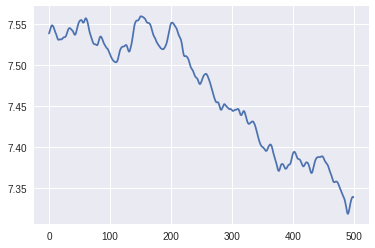

In [24]:
plt.plot(scaled_signal[1000:1500])
#plt.ylim(0,10)

In [60]:
# # first and last readings are a little haywire
# output = output[1:-1]

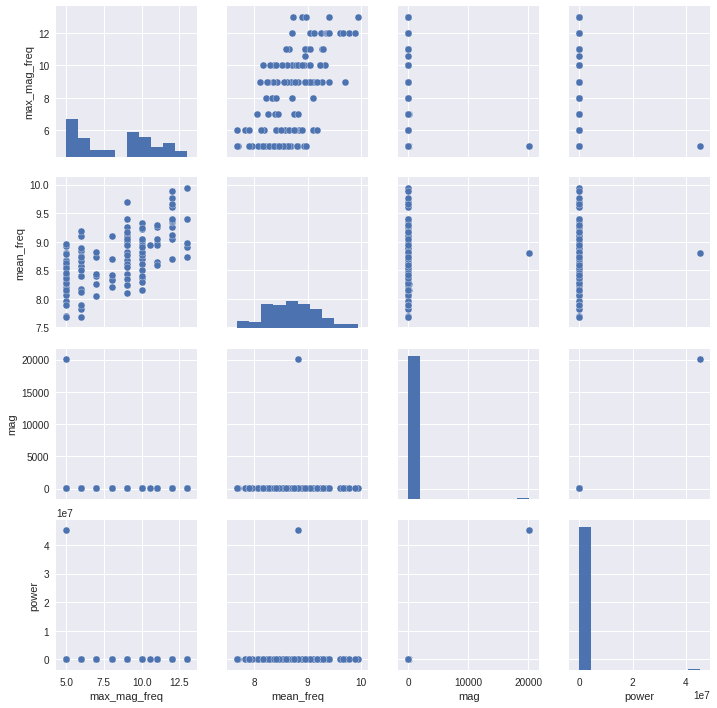

In [61]:
# pairplots are good for giving you a visual sense of data distributions and if
# there are any obvious clusters
sns.pairplot(pd.DataFrame(output, columns=["max_mag_freq", "mean_freq", "mag", "power"]))

### Use max magnitude frequency for KMeans

In [63]:
# output contains [max magnitude frequency, mean frequency, 
# sum of magnitude, power (i.e. mag**2)]
features = [3]
X_data = np.array(output)[:,features]

In [64]:
training_data = StandardScaler().fit_transform(X_data)

In [65]:
cluster = KMeans(n_clusters=4)

In [66]:
results = cluster.fit_predict(X_data)

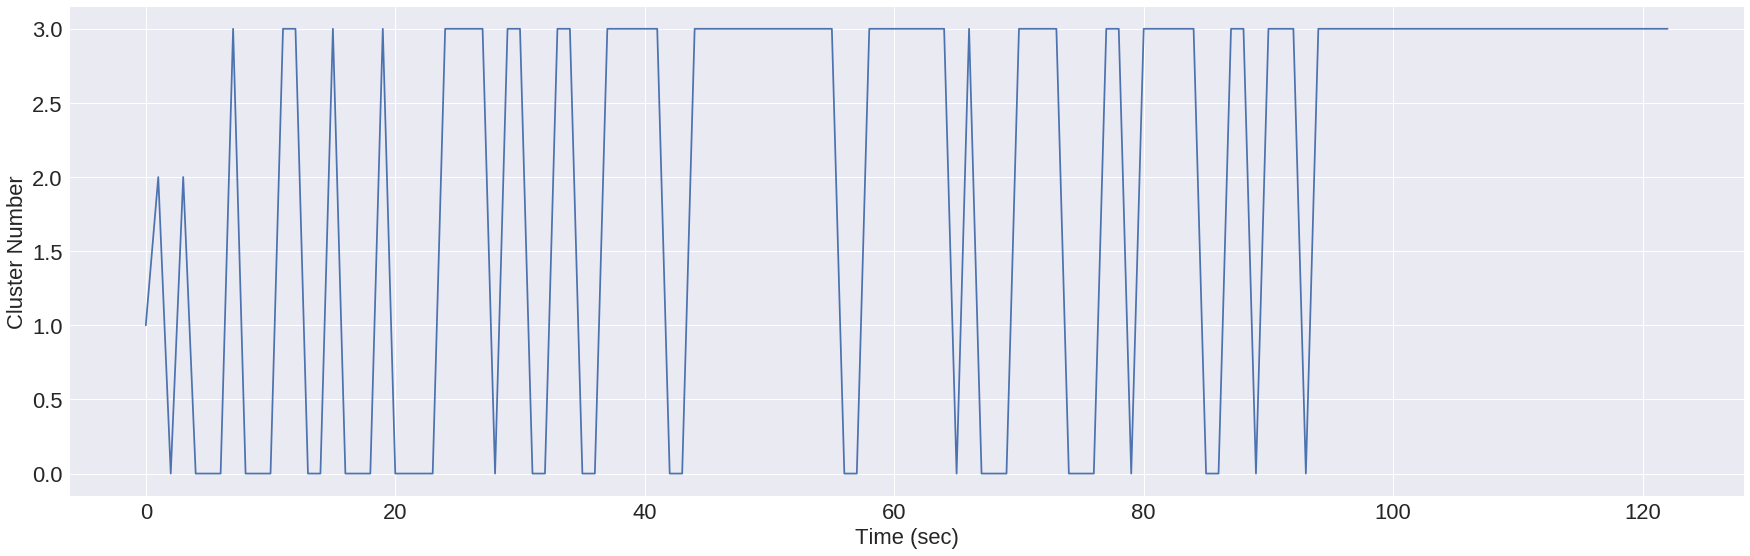

In [67]:
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(0,len(results)), results)
plt.xlabel('Time (sec)',fontsize=22)
plt.ylabel('Cluster Number',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

#### It appears that this feature isn't perfect for clustering everything but it DOES start to carve out the eyes closed portions.
- I'm sure my alpha signal wasn't perfectly steady so I'm not surprised there are multiple cluster assignments between second 20-40
- This feature can't really tell the difference between jaw clenching and head shaking, so we can look at finding that feature next

### Use magnitude sum within the window for KMeans

In [32]:
# output contains [max magnitude frequency, mean frequency, 
# sum of magnitude, power (i.e. mag**2)]
features = [2]
data = np.array(output)[:,features]

In [33]:
training_data = scaler.fit_transform(data)

In [34]:
cluster = KMeans(n_clusters=4)

In [35]:
results = cluster.fit_predict(data)

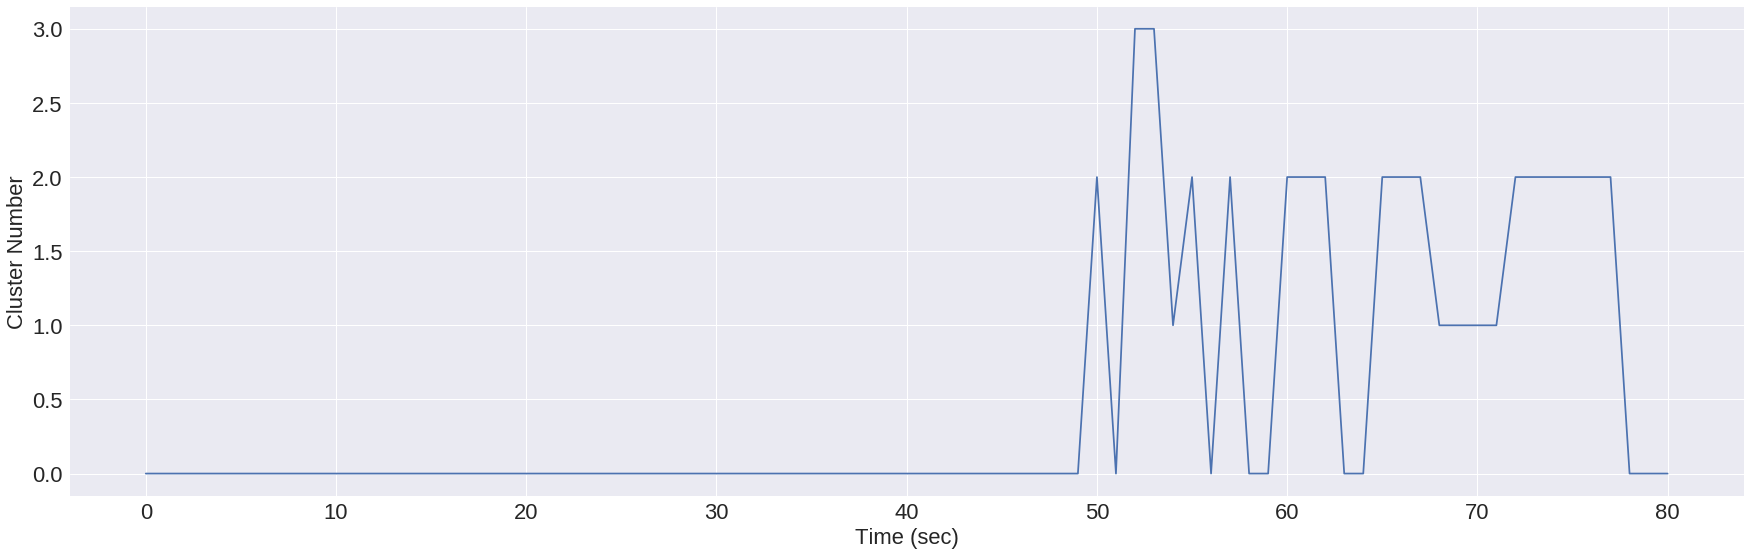

In [36]:
fig, ax = plt.subplots(figsize=(30,9))
ax.plot(range(0,len(results)), results)
plt.xlabel('Time (sec)',fontsize=22)
plt.ylabel('Cluster Number',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

#### It appears that this feature isn't perfect for clustering everything either but it DOES start to break up the jaw clenching and head shaking.
- We're probably seeing the faults of the KMeans algorithm here..
- Since the variance of the magnitude feature within the jaw clenching and head shaking portion of the segment is so high, it works on minimizing variance within those clusters, while the lower variance normal and eyes closed segment looks like 1 blob that doesn't need to be broken up

### Here we learned a couple things:
- What features can be created to summarize the EEG signals
- What those features might be good for